<a href="https://colab.research.google.com/github/rubanzasilva/fastAiProjects/blob/main/AntelopeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Full stack Antelope classification App**

After training a machine learning model you need to deploy it to show potential stakeholders what the results would look like ( With a decent UI, not jupyter notebook ) to achieve any sort of buyback from the people/business that potentially want and can pay for this type of service.

I always knew not everyone in the orgarnization is going to interact with the model through jupyter notebook hence you need to deploy a full stack pipeline.

2 lessons into practical deep learning for coders 2022, I can already do that in under 10 minutes, albeit with hugging face spaces + gradio which am not sure existed in 2019.

Just for background, i had been using fastai since then, i just hadnt fully taken the class just took a lesson and started applying.

Late last year, i realised i had to do just that to fully grasp the underlying concepts.

Following a pattern of sorts from tanishq's dogs vs cats blog post, I decided to blog something similar where i deploy an antelope classifier model to hugging face spaces and build a web interface with gradio.The antelope dataset used to train the model is scrapped from duck duck go.

With this we provide a prediction of the label showing which class the antelope belongs to and it’s corresponding confidence.


## Antelope Classification model - Introduction

Anyone who has travelled to Uganda will know that it is blessed with rich ecosystem that accommodates various kinds of species of Animals.

On a recent drive through Queen Elizabeth national park in Katungulu, I happened to spot a number of what seemed to be antelopes even grabbed a snap.



### Imports
Import fastbook which sets up all the dependencies youll need to complete this notebook
This also mounts google drive in colab

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from fastai.vision.widgets import *

### Data collection
For any machine learning one of the most important and starting points is the data.
For the above classification task, We search and scrape the web using duck duck go for images of antelopes. Duck duck go at this point doesnt require any API keys to pull images from the web.

To use bing etc you will need an API key which you can get after your free sign up.

In the cell below, we search duck duck go for one image, download it then display just to test our scraping functionality

In [ ]:
urls = search_images_ddg('Uganda Kob', max_images=1)
urls[0]

'https://live.staticflickr.com/7180/6861466457_1223536370_b.jpg'

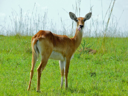

In [ ]:
dest = 'images/ugandaKob.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(128,128)

Above is a preview of the image we just downloaded resized to 128 x 128 px.
All images are converted into a tensor then fed to the dataloaders.
Images are passed to a dataloader as tensors, hence they are all converted to tensor and must be the same size.
We always apply the same transoformations across all images.

Define search terms that our chosen search engine will search for.
A path where the downloads will be stored is defined.
In this case, we shall be searching for images with the defined search terms for types of antelopes below

In [2]:
#search terms and path
antelope_types = 'Eland', 'Greater Kudu', 'Hartebeest', 'Oryx', 'Defassa Waterbuck', 'Sitatunga', 'Impala ', 'The lesser Kudu', 'Grant’s Gazelle', 'Reedbuck', 'Uganda Kob'

path = Path('antelope')

In [3]:
from time import sleep

for o in antelope_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} antelope'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} antelopes in a herd'))
    sleep(10)
    download_images(dest, urls=search_images_ddg(f'{o} antelope low resolution images'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
antelope_b_types = 'Forest duiker','Harvery’s red duiker', 'Blue duiker', 'Peter’s duiker','Black fronted duiker','Grey duiker','Oribi','Klipspringer','Guenther’s dik dik', 'Bates’s pygmy',
'sable', 'roan', 'nyala', 'bushbuck', 'tsessebe', 'steenbok'

('sable', 'roan', 'nyala', 'bushbuck', 'tsessebe', 'steenbok')

In [ ]:
for o in antelope_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} antelope'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} antelopes in a herd'))
    sleep(10)
    download_images(dest, urls=search_images_ddg(f'{o} antelope low resolution images'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [4]:
!ls 

antelope  gdrive  sample_data


In [ ]:
!ls antelope/Oryx

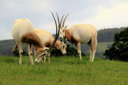

In [ ]:
im = Image.open('antelope/Oryx/7579849e-002d-46df-9306-c0caeecb31c6.jpeg')
im.to_thumb(128,128)

Remove failed images
Some of the images downloaded are incorrect etc.
We use a verify_images function to iterate through our downloaded dataset, check for corrupt images ( by finding the images that cant open ) and remove the failed links

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

33

### Define datablock
We need to put the data in a format that can be used to train our models by creating a ***dataloader*** object.
A datablock API helps us customize our dataloaders object by telling fastai the four things we need to define a dataloaders class.


*   The type of data we are working with ( blocks )
*   How to get the list of items ( get_items )
*   How to label these items ( get_y )
*   How to create a validation set ( splitter )




In [ ]:
antelopes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
get_image_files

<function fastai.data.transforms.get_image_files(path, recurse=True, folders=None)>

In [ ]:
dls = antelopes.dataloaders(path)

Dataloaders class provides images for processing in batches of a few items at a go.
Below is an example of such a batch i.e batch of 64 ( the default ) gives you 64 items at a time.

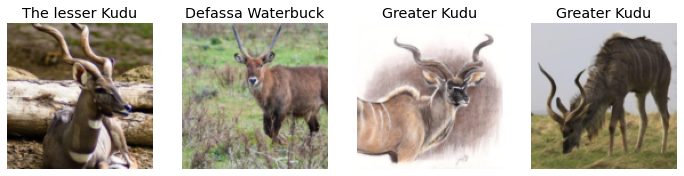

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

### Data Augmentation

**Data augmentation** refers to creating random variations of the inout data such that it appears differenct without actually changing the fundmental meaning of the data for example flipping, perspective warping, brigtnes and contrast variations.

Fastai provides us with an `aug_transforms` function which provides us with a set of standard augmentations that have been found to work pretty well.

We apply these transforms to the entire batch using the `batch_tfms` parameter.

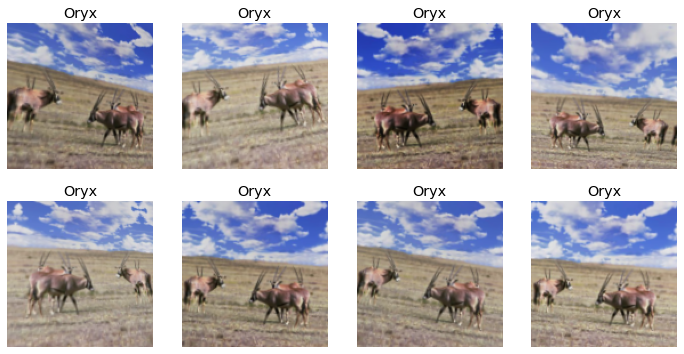

In [ ]:
antelopes = antelopes.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = antelopes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

In [ ]:
antelopes = antelopes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = antelopes.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0012022644514217973)

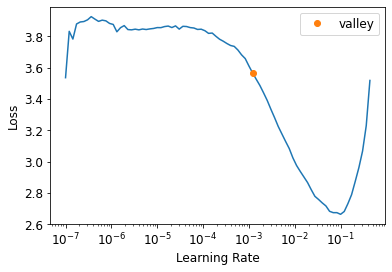

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.952197,1.206439,0.420673,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.740342,1.063716,0.365385,00:12
1,1.527361,0.930783,0.300481,00:14
2,1.326769,0.882598,0.259615,00:12
3,1.131107,0.866451,0.264423,00:11
4,0.964451,0.787160,0.221154,00:10
5,0.833516,0.793170,0.216346,00:13
6,0.742448,0.791806,0.206731,00:12
7,0.668303,0.774564,0.194712,00:12
8,0.603664,0.772363,0.199519,00:11
9,0.562561,0.763189,0.197115,00:12


Confusion matrix for visualizing model results

Fastai allows us to see the results of our model using a confusion matrix.For example if we want to see how many teddy bears are being classified correctly vs incorreclty.

The rows represent the actual labels of the bears in the dataset plotted against the resulting predictions from the model in the columns.

The values in the diagonal represent the correctly classfied while the off- diagonal values represent the incorrectly classified images.




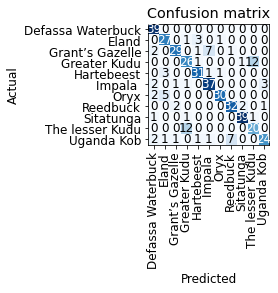

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Top losses
We plot our images based off loss. This helps us look at the images with the highest loss and we try to look for patterns to theorize whats causing this.
A high loss results from high model confidence in a misclassfied image or low confidence in a correclty classified image.
This can result from issues in the dataset, the model or both.

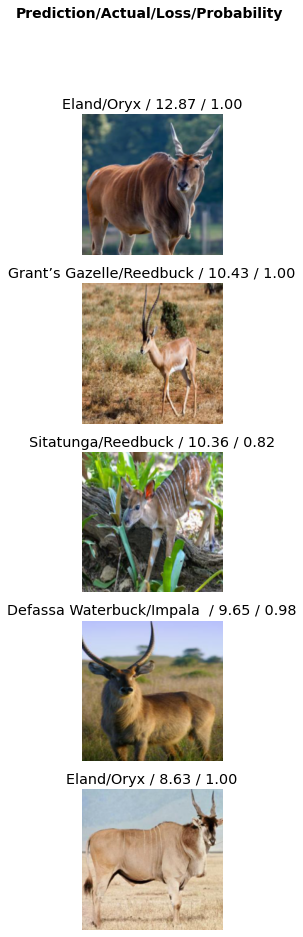

In [ ]:
interp.plot_top_losses(5, nrows=5)

fastai ImageClassifierCleaner

As unintuitive as it seems, training a model before data cleaning can help us identify where some of the issues in our dataset which speeds up our data cleaning process.

Fastai has a GUI tool that enables to view our input data from either training or validation.
Furthermore it enables us to delete, re-label and clean our data in various ways.
This GUI also sorts images based off loss enabling us to edit the images giving our model issues first.

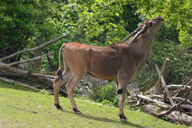

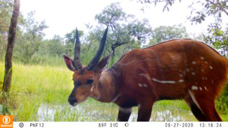

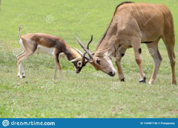

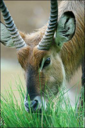

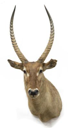

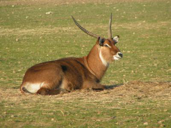

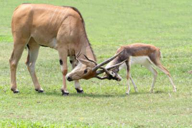

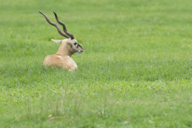

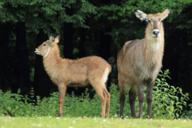

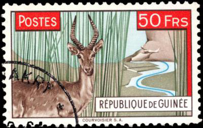

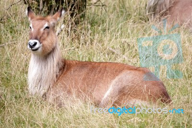

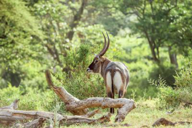

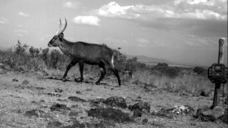

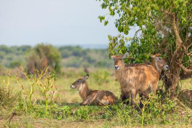

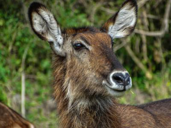

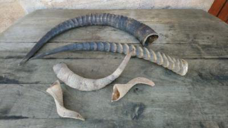

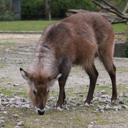

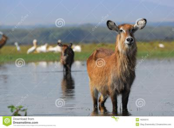

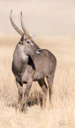

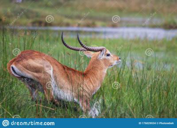

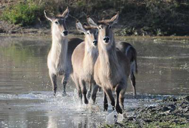

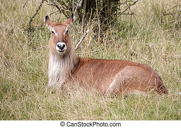

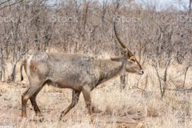

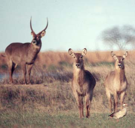

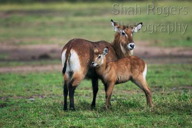

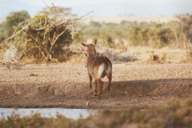

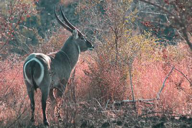

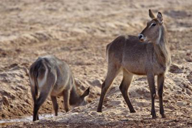

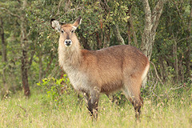

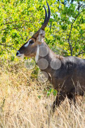

In [ ]:
#hide_output
#images are ordered by loss/confidence
cleaner = ImageClassifierCleaner(learn)
cleaner

The actual functions that execute above chosen tasks i.e. deleting or re-labelling

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Export Model
You have to export your model so that you can use the model for inference outside of this session.

We use the export method for this. This saves the model architecture, parameters and the definition of how we created our data loaders which defines the transforms to be performed on the dataset etc.

In [ ]:
learn.export('antelopeClassifier.pkl')

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bearClassifier.pkl')]

### Using the Model for Inference

We use the load_learner method to load a the model that was trained and exported above.
In this case, we already have our model loaded hence no need to call load_learner but we see load_learner called in the notebook used for inference.

In [ ]:
#hide
#learn_inf = load_learner(path/'bearClassifier.pkl')

Pass a filename of an image to the predict method to do inference on that image.

In [ ]:
!ls sample_data/

anscombe.json		      IMG_9890.jpeg	     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [ ]:
learn.predict('sample_data/IMG_9890.jpeg')

#we would have used this incase we had used the above load_learner method
#learn_inf.predict('images/grizzly.jpg')

('Reedbuck',
 TensorBase(7),
 TensorBase([0.0163, 0.0047, 0.2014, 0.2379, 0.0038, 0.0147, 0.0654, 0.3663, 0.0120, 0.0640, 0.0136]))

This returns the predicted category, 

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [ ]:
learn.dls.vocab

['Defassa Waterbuck', 'Eland', 'Grant’s Gazelle', 'Greater Kudu', 'Hartebeest', 'Impala ', 'Oryx', 'Reedbuck', 'Sitatunga', 'The lesser Kudu', 'Uganda Kob']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

### Potential Issues

In the image i took of my phone, i can actually see what appears to be more than one class of antelopes.
Hence since an image is classifying the image as a whole, results might be based of one class only.

## Turning Your Model into an Online Application

Now we know how to save and export the model, load it and use it for inference.
In the same parent folder, we create another .ipynb file where we load our saved model, define a fuction to do inference, and create a web interface for it using gradio.

The model is uploaded and served via Hugging face spaces.

Terminate this session, and navigate to the parent directory, open bearClassifierInference.ipynb and run the cells

